# Project 1: Navigation

---

For this project, I have trained an agent to navigate and collect bananas in a large, square world.  

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.  Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas. 

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  Given this information, the agent has to learn how to best select actions.  Four discrete actions are available, corresponding to:
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.


## Implementation 

I built and trained a DQN agent using PyTorch and NumPy. The relevant code can be found in `dqn_agent.py`and `model.py`in the same directory as this notebook. What follows is a brief description of the implementation techniques and the parameters I have used.

### 1. Target network with Polyak updating

For stability reasons, it is important to fix the target network when evaluating experiences. Thus, we keep two sets of parameters: $\theta_{local}$ and $\theta_{target}$. Instead of copying the parameters $\theta_{local}$ into $\theta_{target}$ every $N$ steps, we use Polyak updating, i.e. interpolation, with parameter $\tau = 10^{-3}$.

```python
def polyak_update(self, local_model, target_model):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
```

### 2. Experience replay with importance sampling

If we just feed our training network with the experiences in the same order as we gather them, consecutive experiences will be highly correlated. This is problematic for several reasons, e.g. concentrating in suboptimal actions while ignoring other promising ones.

Thus we decorrelate the experiences using a FIFO buffer with $N=10^5$ entries, and during training, we sample them randomly in batches of $Size_{batch}=128$. 

In addition, it has been shown that priming sampling of the most informative experiences helps with the training. For each experience, we assign a priority $w_i$ equal to the absolute error of the expected and the actual value of $Q(a \mid s)$. 

$$ p_i = \frac {(w_i + \varepsilon)^\eta}{\sum_j{(wj + \varepsilon)^\eta}}, 
\varepsilon = 0.0001 , \eta = 0.5 $$

Finally, oversampling some experiences has an effect on the learned distribution. Thus, we have to scale down the losses according to the experience weight. This effect is only significant during the last stages of the training, There is a parameter $\beta = 1.0$ that we can change during training and controls the magnitude of the scaling.

```python
# Compute loss and scale it according to the priority weight
loss = F.mse_loss(q_expected, q_targets, reduce=False)
loss /= (len(self.memory) * weights) ** self.priority_weight_beta
loss = loss.mean()
```

### 3. Double DQN

The vanilla DQN algorithm overestimates $Q$ values as it uses $\arg\max$ of the actions. In order to calculate an unbiased estimation, we use two different networks: one to find the $\arg\max_{a'_i} {Q(s,a'_i)}$, and other to calculate the value of this particular state-action. The good news is that we don't need to create a new network, as we can use the $Q_{local}$ network for finding the action, and the $Q_{target}$ to calculate the $Q$ values.

```python
# Get max predicted Q values for next states using Double DQN
q_targets_next_actions = self.qnetwork_local(next_states).detach().argmax(1, keepdim=True)
q_targets_next = self.qnetwork_target(next_states).detach().gather(1, q_targets_next_actions)
```


### 4. Duel network

Finally, we can make our DQN's life easier building two different regression networks, one for the *state-value* and other for the *action advantages* (i.e. the deviation from the state-value for each action). Unfortunately, we just cannot naïvely apply a linear combination of the output of these subnetworks to calculate the $Q$-value, as we would lose the identity of each stream. Nevertheless, we can enforce the identity of the combining streams by substracting the mean value (or the maximum value) from the *action advantages*. This way, any common offset from the advantages is cancelled and has to be learned in the state-value branch. This particular implementation substracts the mean, as it works well even if it diverges from the definition of $Q$-value (i.e. max action value)

One advantage of this technique is that it only requires changes in the NN model, `model.py`. Below you can see the  final network architecture, consisting of only lineal units with ReLU non-linearities and the duel network recombination layer described above:

```python
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed,
                 fc1_units=64, fc2_units=64,
                 v1_units=32, v2_units=32,
                 a1_units=32, a2_units=32):
        # ...
        
        # Common network
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # Duel network - V stream
        self.v1 = nn.Linear(fc2_units, v1_units)
        self.v2 = nn.Linear(v1_units, v2_units)
        self.v3 = nn.Linear(v2_units, 1)

        # Duel network - A stream
        self.a1 = nn.Linear(fc2_units, a1_units)
        self.a2 = nn.Linear(a1_units, a2_units)
        self.a3 = nn.Linear(a2_units, action_size)

        #  ...
        
    def forward(self, state):     
        
        fc1 = F.relu(self.fc1(state))
        fc2 = F.relu(self.fc2(fc1))

        v1 = F.relu(self.v1(fc2))
        v2 = F.relu(self.v2(v1))
        v3 = self.v3(v2)

        a1 = F.relu(self.a1(fc2))
        a2 = F.relu(self.a2(a1))
        a3 = self.a3(a2)

        # Use the mean in order to keep the identity of the branches
        # as in formula (9) of https://arxiv.org/pdf/1511.06581.pdf
        q = v3 + (a3 - a3.mean(dim=1, keepdim=True))
        
        return q
```

## Training of the DQN agent

### 1. Import required libraries

In [1]:
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from matplotlib import pyplot as plt
from dqn_agent import Agent
from model import QNetwork

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# Change this line, according to your environment
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training function

This is the definition of the training function we use to train our DQN network. It uses $\varepsilon$*-greedy* policy with decay.

In [7]:
def dqn(env, agent, n_episodes=1000, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
 
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tScore: {}\tAverage Score: {:.2f}\teps: {:.2f}'.format(i_episode, score, np.mean(scores_window), eps), end="")
    return scores

### 4. Launch training and save the DQN parameters

The following code launches an environment and executes the training of the agent. It will take several minutes to finish, be patient!

In [10]:
# Get state and action information about the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state

# Create an agent
agent = Agent(QNetwork, len(state), brain.vector_action_space_size, seed=42)

# Execute training
scores = dqn(env, agent, n_episodes=1000, eps_start=0.995)

# Save trained parameters
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

Episode 1000	Score: 18.0	Average Score: 16.64	eps: 0.01

### 5. Show training progress results

We can see that the agent has learnt the task early and that the average score is higher than the goal of 13. 

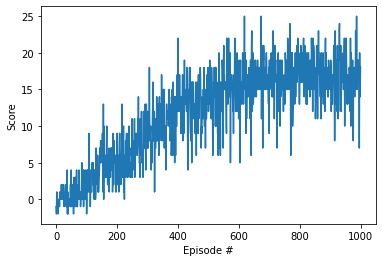

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Execute an episode with the trained agent

The following code shows an episode of the trained agent interacting with the environment at normal speed (`train_mode=False`).

In [16]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

# Create agent
agent = Agent(QNetwork, len(state), brain.vector_action_space_size, seed=42)

# Load stored parameters
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 20.0


### 7. Video of the agent in action

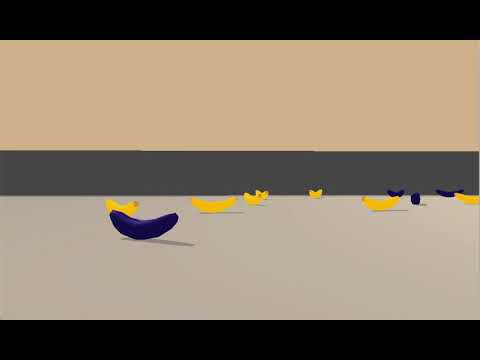

In [27]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('5kDRF2EdKRc')

In [ ]:
env.close()